Testar o ElasticNet para ver se é possível uma solução melhor em relação aos coeficientes

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50.0,1120.0,283.0,697.0,264.0,2.1250,140000.0,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50.0,2239.0,455.0,990.0,419.0,1.9911,158700.0,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 17564 non-null  float64
 1   latitude                  17564 non-null  float64
 2   housing_median_age        17564 non-null  float64
 3   total_rooms               17564 non-null  float64
 4   total_bedrooms            17564 non-null  float64
 5   population                17564 non-null  float64
 6   households                17564 non-null  float64
 7   median_income             17564 non-null  float64
 8   median_house_value        17564 non-null  float64
 9   ocean_proximity           17564 non-null  object 
 10  median_income_cat         17564 non-null  int64  
 11  rooms_per_household       17564 non-null  float64
 12  population_per_household  17564 non-null  float64
 13  bedrooms_per_room         17564 non-null  float64
dtypes: flo

In [4]:
coluna_target=['median_house_value']

coluna_one_hot_encoder=['ocean_proximity']

coluna_ordinal_encoder=['median_income_cat']


In [5]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_robust_scaler 

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [6]:
pipeline_robust= Pipeline(steps=[
    ('robust_scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False))
])    

preprocessamento = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_encoder),
        ('one_hot', OneHotEncoder(drop='first'), coluna_one_hot_encoder),
        ('robust_scaler_poly', pipeline_robust, colunas_robust_scaler),
    ],
)



In [7]:
X=df.drop(columns=coluna_target)
y=df[coluna_target]

In [8]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42.0,2555.0,665.0,1206.0,595.0,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50.0,1120.0,283.0,697.0,264.0,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50.0,2239.0,455.0,990.0,419.0,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [9]:
y.head()

,median_house_value
0,452600.0
1,358500.0
2,226700.0
3,140000.0
4,158700.0


In [10]:
param_grid = {
    #avaliar se relações não lineares melhoram o modelo. 
    #assess whether non-linear relationships improve the model.
    'regressor__preprocessor__robust_scaler_poly__poly__degree':[1, 2, 3],
    #testar valores alpha (maior ou menor regulazição dos dados)
    #test alpha values ​​(greater or lesser regularization of data)
    'regressor__reg__alpha': [1E-2, 5E-2, 0.1, 0.25, 0.5, 1.0],
    #controla a proporção entre L1 (Lasso) e L2 (Ridge).
    #controls the ratio between L1 (Lasso) and L2 (Ridge).
    'regressor__reg__l1_ratio':[0.1, 0.25, 0.5, 0.75, 0.9],
}

In [11]:
grid_search = grid_search_cv_regressor(
    regressor=ElasticNet(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution='normal'),
    param_grid=param_grid,
)
grid_search    

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0],
                         'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [12]:
grid_search.fit( X,y)   

Fitting 5 folds for each of 90 candidates, totalling 450 fits


D:\ProgramFiles\anaconda\env\machine_learning\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.357e+02, tolerance: 1.796e+00
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0],
                         'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [13]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 0.01,
 'regressor__reg__l1_ratio': 0.1}

ratio 0.1 indica muito mais para Ridge do que o lasso

In [14]:
grid_search.best_score_

-51307.61753965764

In [15]:
coefs=dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

In [16]:
coefs[coefs['coeficiente']==0]

,coeficiente
robust_scaler_poly__housing_median_age population rooms_per_household,-0.0
robust_scaler_poly__households population_per_household total_rooms,0.0
robust_scaler_poly__housing_median_age population population_per_household,0.0
robust_scaler_poly__housing_median_age population total_rooms,-0.0
robust_scaler_poly__housing_median_age population total_bedrooms,-0.0
...,...
robust_scaler_poly__bedrooms_per_room median_income total_rooms,-0.0
robust_scaler_poly__bedrooms_per_room total_rooms^2,-0.0
robust_scaler_poly__bedrooms_per_room total_bedrooms^2,-0.0
robust_scaler_poly__bedrooms_per_room total_bedrooms total_rooms,-0.0


In [17]:
coefs[coefs['coeficiente'].between(-0.1, 0.1) & (coefs['coeficiente']!=0)]

,coeficiente
robust_scaler_poly__bedrooms_per_room^2 median_income,-0.083262
robust_scaler_poly__bedrooms_per_room^2 latitude,-0.075467
robust_scaler_poly__housing_median_age latitude,-0.068449
robust_scaler_poly__median_income^2,-0.065396
robust_scaler_poly__median_income population_per_household,-0.063625
...,...
robust_scaler_poly__total_bedrooms,0.075969
robust_scaler_poly__housing_median_age population_per_household^2,0.086131
robust_scaler_poly__housing_median_age,0.087463
robust_scaler_poly__median_income total_bedrooms,0.092816


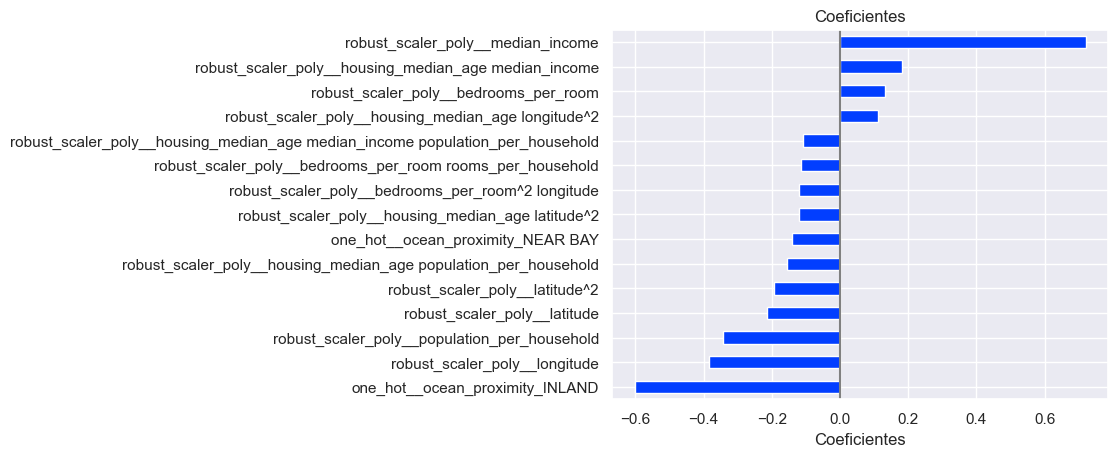

In [18]:
plot_coeficientes(coefs[~coefs['coeficiente'].between(-0.1,0.1)])

In [19]:
target_transformer = PowerTransformer()

regressors = {
    'DummyRegressor':{
        'preprocessor':None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None,
    },
    'LinnearRegression':{
        'preprocessor':preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },
  'LinnearRegression_target':{
        'preprocessor':preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': QuantileTransformer(output_distribution='normal'),
    },
    'ElasticNet_grid_search':{
        'preprocessor':grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer':grid_search.best_estimator_.transformer,
    },
}    
resultados= {
    nome_modelo: treinar_e_validar_modelo_regressao(X,y,**regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)
df_resultados

D:\ProgramFiles\anaconda\env\machine_learning\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.184e+01, tolerance: 1.442e+00
  model = cd_fast.enet_coordinate_descent(
D:\ProgramFiles\anaconda\env\machine_learning\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.345e+01, tolerance: 1.435e+00
  model = cd_fast.enet_coordinate_descent(
D:\ProgramFiles\anaconda\env\machine_learning\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.003049,0.00455,-0.000081,-77516.042766,-96239.705692,0.007598
1,DummyRegressor,0.00355,0.004115,-0.000146,-75787.787194,-95217.629397,0.007665
2,DummyRegressor,0.003004,0.003232,-0.001737,-76753.598961,-96253.253947,0.006236
3,DummyRegressor,0.002002,0.004134,-0.000101,-76837.804811,-95983.885799,0.006136
4,DummyRegressor,0.003116,0.003111,-0.000114,-76617.245449,-96182.764729,0.006227
5,LinnearRegression,0.060637,0.008516,0.682162,-39855.690921,-54254.958115,0.069152
6,LinnearRegression,0.026537,0.008442,0.66999,-40272.565406,-54695.230224,0.03498
7,LinnearRegression,0.027181,0.008566,0.649247,-42178.059246,-56955.988686,0.035747
8,LinnearRegression,0.02678,0.007728,0.669873,-40806.492452,-55146.31876,0.034508
9,LinnearRegression,0.024985,0.008347,0.669023,-40788.496555,-55331.351171,0.033332


In [20]:
df_resultados.groupby('model').mean().sort_values(by='test_neg_root_mean_squared_error')	


,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.002944,0.003828,-0.000436,-76702.495836,-95975.447913,0.006773
LinnearRegression,0.033224,0.00832,0.668059,-40780.260916,-55276.769391,0.041544
LinnearRegression_target,0.031942,0.009304,0.678243,-38675.013744,-54418.57045,0.041246
ElasticNet_grid_search,19.243841,0.025622,0.713965,-36007.437419,-51300.964307,19.269463


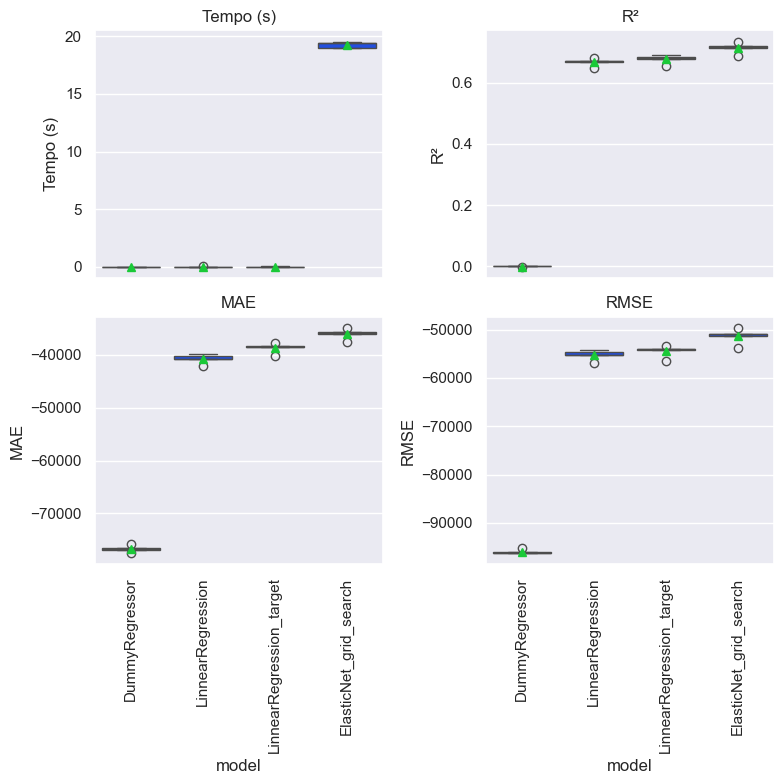

In [21]:
plot_comparar_metricas_modelos(df_resultados)

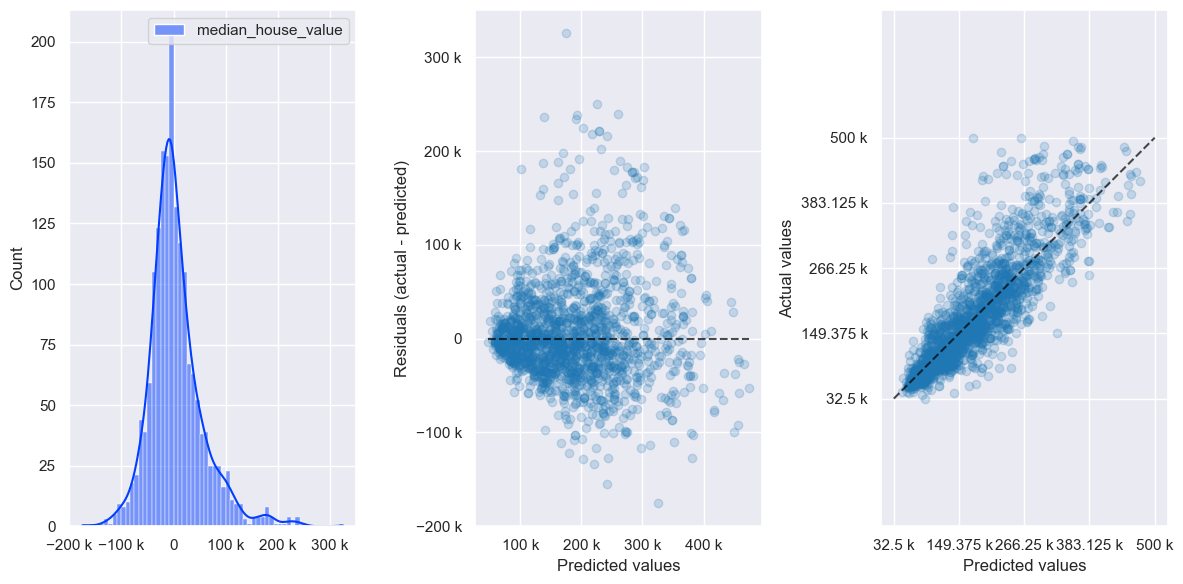

In [22]:
plot_residuos_estimador(grid_search.best_estimator_, X,y, fracao_amostra=0.1, eng_formatter=True)


Conclusão:

Os dados têm muitas variáveis correlacionadas ou se todas as variáveis são relevantes, o Ridge tende a performar melhor que o Lasso, pois o Lasso pode selecionar apenas uma variável de um grupo de variáveis correlacionadas, enquanto o Ridge mantém todas, mas reduzindo seus coeficientes. O modelo está tendendo para o Ridge Regression: o l1_ratio está próximo de 0 (10% L1 e 90% L2).

O alpha é baixo, indicando que a regularização é suave, mas ainda suficiente para evitar overfitting, especialmente com polinômios de grau 3.

A escolha de polinômios de grau 3 sugere que o modelo está tentando capturar relações não lineares, e a regularização L2 ajuda a controlar a complexidade.

Conclusion:

The data has many correlated variables or if all variables are relevant, Ridge tends to perform better than Lasso, since Lasso can select only one variable from a group of correlated variables, while Ridge keeps all of them, but reduces their coefficients. The model is tending towards Ridge Regression: the l1_ratio is close to 0 (10% L1 and 90% L2).

The alpha is low, indicating that the regularization is mild, but still sufficient to avoid overfitting, especially with degree 3 polynomials.

The choice of degree 3 polynomials suggests that the model is trying to capture non-linear relationships, and L2 regularization helps to control complexity.